In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from functools import partial
from scipy.optimize import curve_fit
import scipy
import statsmodels.api as sm

In [2]:
#load data
pair = "XCAD-USDT"
exchange = "GATEIO"

start = datetime.datetime(2022, 11, 1)
end = datetime.datetime(2022, 11, 4)

books = pd.read_parquet("/Users/miguelmeier/Jupiter_Notebook/ser_project/data/test/books_GATEIO_AVAX-USDT_2022-11-01.parquet")
trades = pd.read_parquet("/Users/miguelmeier/Jupiter_Notebook/ser_project/data/test/trades_GATEIO_AVAX-USDT_2022-11-01.parquet")


In [3]:
def smallest_increment(number):

    # Convert the number to a string and split by the decimal point
    parts = str(number).split('.')
    
    # If there's a decimal part
    if len(parts) > 1:
        # Count the number of digits after the decimal point
        decimal_places = len(parts[1])
        
        # Return the smallest increment based on the decimal places
        return 10 ** -decimal_places
    else:
        # If there's no decimal, the smallest increment is 1
        return 1

tick_size = smallest_increment(trades["price"].iloc[0])
books['mid'] = (books['bid_0_price'] + books['ask_0_price']) / 2

In [4]:
# delete trades inside of spread:
delete_fake = True

#percentage of trades within spread
def find_closest_timestamp(ts, ts_list):
    """Find the closest timestamp in ts_list to ts."""
    deltas = np.abs((ts_list - ts).total_seconds())
    return ts_list[np.argmin(deltas)]
    target = row.name + pd.Timedelta(seconds=5)
    return ts_index.get_loc(target, method='nearest')

tick_size = smallest_increment(trades["price"].iloc[0])
book1 = books.copy()
# Merge trades and l1 data
book1['future_bid'] = book1.bid_0_price.shift(-1)
book1['future_ask'] = book1.ask_0_price.shift(-1)

df = pd.merge_asof(
	left = trades.rename(columns = {'received_time': 'trade_received_time'}),
	right = book1.rename(columns = {'received_time': 'depth_received_time'}),
	left_on = 'trade_received_time',
	right_on = 'depth_received_time',
	tolerance = pd.Timedelta(minutes = 60),
)
df = df.dropna().reset_index(drop = True)

# Detection logic
epsilon = tick_size
df['fake'] = (
	# Trade is fake when its inside spread (+- some epsilon, perhaps one tick)
	(df['price'] > df['bid_0_price'] + epsilon) & 
	(df['price'] < df['ask_0_price'] - epsilon) &
	# To prevent false positives, we also assume we didn't receive the next depth update yet
	(df['price'] > df['future_bid'] + epsilon) & 
	(df['price'] < df['future_ask'] - epsilon)
)

fake_volume = df.loc[df['fake'] == 1, 'quantity'].sum()
all_volume = df['quantity'].sum()

# Note that this method has some false positives, but still leads to better & cleaner data for most use cases
print('Fake trade percentage', df['fake'].mean() * 100)
print('Fake volume percentage', fake_volume / all_volume * 100)

trades = df[["side","quantity","price","trade_received_time", "origin_time_x", "fake", "trade_id"]]
trades["received_time"] =trades["trade_received_time"]

if delete_fake:
    print("drop fake trades!")
    trades = trades[~trades["fake"]]

Fake trade percentage 18.352516098953934
Fake volume percentage 39.51776397408518
drop fake trades!


/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_29011/1202978936.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades["received_time"] =trades["trade_received_time"]


In [5]:
amount_of_rows = 1
books['ob_imbalance_1'] = (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) - sum(books[f'ask_{i}_size'] for i in range(amount_of_rows))) / (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) + sum(books[f'ask_{i}_size'] for i in range(amount_of_rows)))

amount_of_rows = 3
books['ob_imbalance_3'] = (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) - sum(books[f'ask_{i}_size'] for i in range(amount_of_rows))) / (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) + sum(books[f'ask_{i}_size'] for i in range(amount_of_rows)))

amount_of_rows = 5
books['ob_imbalance_5'] = (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) - sum(books[f'ask_{i}_size'] for i in range(amount_of_rows))) / (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) + sum(books[f'ask_{i}_size'] for i in range(amount_of_rows)))

amount_of_rows = 10
books['ob_imbalance_10'] = (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) - sum(books[f'ask_{i}_size'] for i in range(amount_of_rows))) / (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) + sum(books[f'ask_{i}_size'] for i in range(amount_of_rows)))

amount_of_rows = 20
books['ob_imbalance_20'] = (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) - sum(books[f'ask_{i}_size'] for i in range(amount_of_rows))) / (sum(books[f'bid_{i}_size'] for i in range(amount_of_rows)) + sum(books[f'ask_{i}_size'] for i in range(amount_of_rows)))


#test
window = 10  

# Calculate the imbalance timeseries
books['imbalance_timeseries'] = books['bid_0_size'] - books['ask_0_size']

# Calculate the rolling mean and standard deviation
books['rolling_mean'] = books['imbalance_timeseries'].rolling(window, min_periods=1).mean()
books['rolling_std'] = books['imbalance_timeseries'].rolling(window, min_periods=1).std()

# To handle the division by zero, we'll replace zeros with a small number
books['rolling_std'] = books['rolling_std'].replace(0, np.finfo(float).eps)

# Now, standardize the imbalance timeseries
books['alpha'] = (books['imbalance_timeseries'] - books['rolling_mean']) / books['rolling_std']



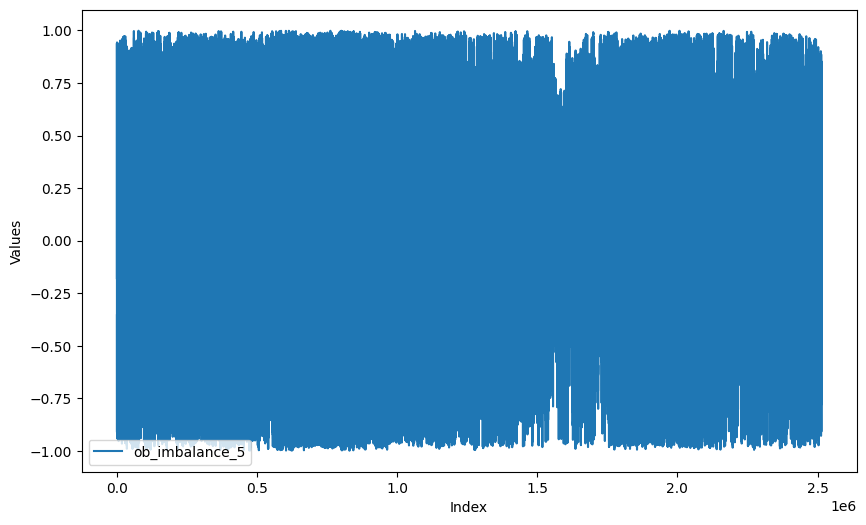

In [6]:
columns_to_plot = ["ob_imbalance_5"]

books[columns_to_plot].plot(figsize=(10, 6)) 
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()